# QEVEC RSE D-Wave tutorial

<b>Goals</b>
- Understand how to (manually) build QUBO/Ising models for real world problems 
    - Objectives
    - Constraints
- Run the quantum annealing using the QUBO/Ising model
- Postprocessing
    - Analyse and display the results
    - Verification (respecting the contraints)
- Use the D-Wave Ocean tools to add constraint to a model
- Use the D-Wave Ocean hybrid methods

## The theory
- Ising vs QUBO
- Eigenproblem
- Objective
- Constraint
- Chain break fraction (majority vote)

### Eigenvalues and eigenvectors

$$
\hat{H}\psi(r) =   \epsilon \ \psi(r)
$$

$$
<\psi(r)|\hat{H}|\psi(r)> =  E
$$

### Binary Quadratic Model

<b>Binary Quadratic Form</b>

<i>Two variables</i>

$$
f(x_{1},x_{2}) = ax_{1}^{2} + bx_{2}^{2} + cx_{1}x_{2} + dx_{1} + ex_{2} + g
$$

$$
x_{1},x_{2} \in {0,1}
$$

$$
f(x_{1},x_{2}) = ax_{1} + bx_{2} + cx_{1}x_{2} 
$$

<i>N variables</i>

$$
f(x_{1},x_{2}) => f(\mathbf{x})
$$

$$
f(\mathbf{x}) = \mathbf{x}^{T}A\mathbf{x}
$$



<b>Ising</b>

$$
E(s) = \sum_{i} h_{i} s_{i} + \sum_{i,j} J_{i,j} s_{i}s_{j} \ \ \ \ \ s_{i} \in \{+1,-1\}
$$

<b>QUBO (Quadratic Unconstrained Binary Problem)</b>
$$
E(x) =   x^{T}Qx = 
    \sum_{i} Q_{i,i} x_{i} + \sum_{i} \sum_{j > i} Q_{i,j} x_{i}x_{j} \ \ \ \ \ x_{i} \in \{0,1\}
    $$

### Solution steps:

- define the system 
- define the model to represent the system (e.g. graph representation)
- map the model represetation to a binary array
- express the energy model as an Ising/QUBO model
- run the annealing N times and analyse the results (energy and configuration)

### Example problems:

- <b>Binary</b>
    - Graph partitioning (2 groups)
    - Vacancies in graphene
- <b>Discrete</b>
    - Graph partitioning (3 groups)
    - Travelling salesperson


# Graph partitioning problem
- Group of N people
- Some couples of people are friends
- Divide them in two groups trying to have as many friends in the same group as possible

- Represent the group as a graph
    - each node represents a person
    - each edge (line between nodes) represents the connection between two friends
- Define an energy model that minimises edges between the two groups
| $$x_{i}$$        | $$x_{j}$$           | Energy  |
| --- |---| ---|
| 0 | 0 | 0 |
| 0  | 1  |   1 |
| 1 | 0      |    1 |
| 1 | 1      |    0 |

- $E = x_i + x_j -2x_{i}x_{j}$
- Constraint: same number of people in the two groups

In [96]:
import networkx as nx
from collections import defaultdict
from itertools import combinations
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite
from dwave.inspector import show
import math
import numpy as np
from quantum_computing_functions import *
from quantum_computing_postprocessing import *

### Generate the network

In [117]:
n_people = 6
G = nx.gnp_random_graph(n_people, 0.25) #(N nodes, probability for edge)

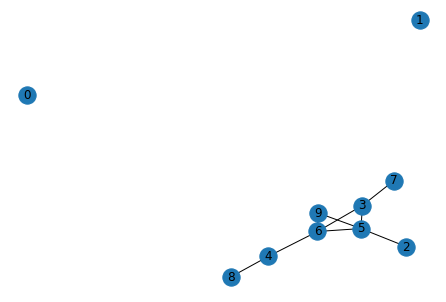

In [101]:
nx.draw(G,with_labels=True)

### QUBO matrix - objective

In [110]:
Q = np.zeros((n_people,n_people))
#Q

In [111]:
#Q = np.zeros((n_people,n_people))
for i, j in G.edges:
    #print(i,j)
    Q[i,i] += 1
    Q[j,j] += 1
    Q[i,j] += -2

In [28]:
Q

array([[ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0., -2.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1., -2.],
       [ 0.,  0.,  0.,  0.,  0.,  2.]])

In [112]:
sampler = EmbeddingComposite(DWaveSampler())
sampleset_qubo = sampler.sample_qubo(Q, num_reads=1000,
                               label='Example - Graph Partitioning - QUBO')

In [22]:
sampleset_qubo.to_pandas_dataframe()

,0,1,2,3,4,5,chain_break_fraction,energy,num_occurrences
0,1,1,1,0,1,1,0.0,0.0,94
1,1,1,1,1,1,1,0.0,0.0,73
2,1,0,0,0,0,0,0.0,0.0,59
3,0,0,1,0,1,1,0.0,0.0,57
4,0,0,0,1,0,0,0.0,0.0,50
5,1,1,0,1,0,0,0.0,0.0,75
6,1,0,1,1,1,1,0.0,0.0,75
7,0,0,0,0,0,0,0.0,0.0,48
8,0,1,0,1,0,0,0.0,0.0,47
9,0,1,0,0,0,0,0.0,0.0,58


### QUBO matrix - constraint

- Constrain how many people are going to be placed in group 1 ($N_{g1}$)
- Same number of people in the two groups


$$
\sum_{i}^{N_{people}}  x_{i} = N_{g1}
$$
$$
\sum_{i}^{N_{people}}  x_{i} - N_{g1} = 0
$$

$$
\left(\sum_{i}^{N_{people}} x_{i} - N_{g1}\right)^{2} = \\
        \sum_{i}^{N_{people}} x_{i}^{2} + 
        \sum_{i}^{N_{people}}\sum_{j>i}^{N_{people}} 2 x_{i} x_{j} - 
        \sum_{i}^{N_{people}} 2 x_{i} N_{g1} +
        N_{g1}^{2} = \\
        \sum_{i}^{N_{people}} \left(1-2N_{g1}\right) x_{i} +
        \sum_{i}^{N_{people}}\sum_{j>i}^{N_{people}} 2 x_{i} x_{j}
$$

Add a scaling coefficient $\gamma$:

$$
\sum_{i}^{N_{people}} \gamma \left(1-2N_{g1}\right) x_{i} +
        \sum_{i}^{N_{people}}\sum_{j>i}^{N_{people}} 2\gamma x_{i} x_{j}
$$

In [113]:
#Q = np.zeros((n_people,n_people))
gamma = 2
for i in G.nodes:
    Q[i,i] += gamma*(1-2*(0.5*n_people))

for i in range(len(G.nodes)):
    for j in range(i+1,len(G.nodes)):
        Q[(i,j)] += 2*gamma

In [114]:
sampler = EmbeddingComposite(DWaveSampler())
sampleset_qubo_c = sampler.sample_qubo(Q, num_reads=1000,
                               label='Example - Graph Partitioning')

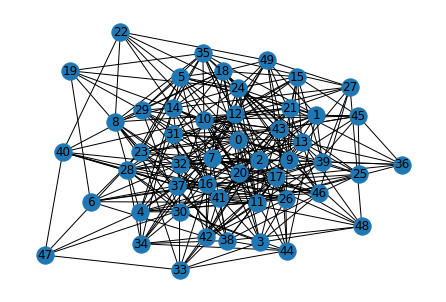

In [115]:
nx.draw(G,with_labels=True)

In [106]:
sampleset_qubo_c.to_pandas_dataframe()

,0,1,2,3,4,5,6,7,8,9,chain_break_fraction,energy,num_occurrences
0,1,1,0,0,1,0,0,1,1,0,0.0,-48.0,33
1,1,1,1,0,1,0,0,0,1,0,0.0,-48.0,64
2,0,0,1,1,0,1,1,0,0,1,0.0,-48.0,44
3,0,0,0,1,0,1,1,1,0,1,0.0,-48.0,28
4,0,0,1,1,0,1,1,1,0,1,0.1,-47.0,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,1,0,1,1,0,0,0,1,1,1,0.0,-42.0,1
232,1,1,0,0,0,0,0,1,1,1,0.1,-46.0,1
233,0,0,1,1,0,1,1,0,1,1,0.1,-45.0,1
234,0,0,0,1,1,1,1,1,0,1,0.1,-46.0,1


In [116]:
#show(sampleset_qubo_c)

'http://127.0.0.1:18000/?problemId=fac946f9-40b3-497d-a4bc-dbef56ab769a'

## Binary Quadratic Model

In [94]:
from dimod import BinaryQuadraticModel

bqm = BinaryQuadraticModel(n_people, vartype='BINARY')

gamma = 2

for i, j in G.edges:
    bqm.add_linear(i,1)
    bqm.add_linear(j,1)
    bqm.add_quadratic(i,j,-2)

bqm.add_linear_equality_constraint(
    [(x,-1) for x in G.nodes],
    constant= 0.5*n_people,
    lagrange_multiplier = gamma,
    )
#bqm.to_numpy_matrix()

In [98]:
sampler = EmbeddingComposite(DWaveSampler())
sampleset = sampler.sample(bqm, num_reads=1000,
                               label='Example - Graph Partitioning- bqm')

In [64]:
sampleset.to_pandas_dataframe()

,0,1,2,3,4,5,chain_break_fraction,energy,num_occurrences
0,1,1,0,1,0,0,0.000000,0.0,160
1,0,0,1,0,1,1,0.000000,0.0,213
2,0,1,0,1,1,0,0.000000,1.0,72
3,0,0,1,1,0,1,0.000000,1.0,49
4,0,1,1,1,0,0,0.000000,1.0,46
5,1,0,0,1,1,0,0.000000,1.0,37
6,0,0,0,1,1,1,0.000000,1.0,62
7,1,1,0,0,1,0,0.000000,1.0,40
8,1,0,0,0,1,1,0.000000,1.0,32
9,1,0,1,0,0,1,0.000000,1.0,22


In [99]:
#show(sampleset)      

'http://127.0.0.1:18000/?problemId=dbba8fcb-bb19-4afa-8476-d22a24bef3a6'

### Verification
- solutions that respect the constraint

### Parameters
- gamma
- chain strength https://support.dwavesys.com/hc/en-us/community/posts/360016697094-What-is-a-chain-
- anneal time

## Vacancies in graphene

In [120]:
from pymatgen.core.structure import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.io.ase import AseAtomsAdaptor
from ase.visualize import view
import copy

lattice = np.array([[ 1.233862, -2.137112,  0.      ],
                   [ 1.233862,  2.137112,  0.      ],
                   [ 0.      ,  0.      ,  8.685038]])

graphene = Structure(lattice, species=['C','C'], coords=[[2/3, 1/3, 0. ],[1/3, 2/3, 0.]])
graphene = SpacegroupAnalyzer(graphene).get_conventional_standard_structure()

scaling_matrix = np.array([[3, 0, 0],
                            [0, 3, 0],
                            [0, 0, 1]])

graphene_supercell = copy.deepcopy(graphene)
graphene_supercell.make_supercell(scaling_matrix)
structure = graphene_supercell
num_sites = graphene_supercell.num_sites

In [121]:
shells = np.unique(np.round(graphene_supercell.distance_matrix[0],5)) 
adjacency_matrix = (np.round(graphene_supercell.distance_matrix,5) == shells[1]).astype(int)
#adjacency_matrix

In [122]:
alpha = 1
Q = np.triu(-adjacency_matrix.astype(int),0)

n_vacancies = 1
n_atoms = num_sites - n_vacancies

gamma = 10

for i in range(num_sites):
    Q[i,i] += gamma*(1-2*n_atoms)
    for j in range(i+1,num_sites):
        Q[i,j] += 2*gamma


In [123]:
sampler = EmbeddingComposite(DWaveSampler())
sampleset_graphene = sampler.sample_qubo(Q, num_reads=1000,
                               label='Example - Vacancies in graphene')

In [124]:
df = sampleset_graphene.to_pandas_dataframe()
df.iloc[:,df.columns != 'chain_break_fraction']

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,energy,num_occurrences
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,-2914.0,24
1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,-2914.0,15
2,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,-2914.0,23
3,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,-2914.0,11
4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,-2914.0,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,-2868.0,1
271,0,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,0,1,-2868.0,1
272,1,1,1,1,1,0,1,1,0,1,1,1,1,1,1,1,1,1,-2901.0,1
273,0,1,0,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,-2869.0,1


# Graph partitioning problem - 3 groups
- Group of N people
- Some couples of people are friends
- Divide them in three groups (A,B,C) trying to have as many friends in the same group as possible

- Represent the group as a graph
    - each node represents a person
    - each edge (line between nodes) represents the connection between two friends
- Define an energy model that minimises edges between the two groups
| $$x_{i}$$        | $$x_{j}$$           | Energy  |
| --- |---| ---|
| A | A | 0 |
| A  | B  |   1 |
| A | C      |    1 |
| B | B      |    0 |
| B | C      |    1 |
| C | C      |    0 |


- Constraint: same number of people in the three groups

- We cannot use binary variables, we need to define a discrete model
- Binary X vector vs discrete
$$
X = |A B C|=|100,010,001|
$$
<i>NB: the commas are just to help visualise the groups, the actual vector is</i>: |100010001|

- One hot encoding

- $ \sum_{i}^{N_{sites}} \left( 1- x_{i_{a}} - x_{i_{b}} - x_{i_{c}}  \right)^{2} = 0    $

In [309]:
n_people = 3
n_groups = 3
num_elements = n_people*n_groups
G = nx.gnp_random_graph(n_people, 0.9) #(N nodes, probability for edge)

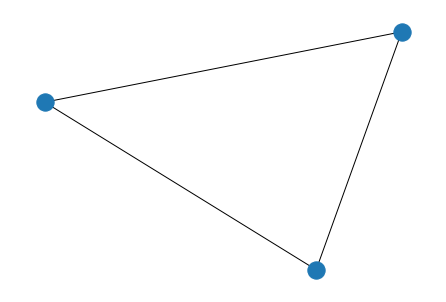

In [310]:
nx.draw(G)

In [321]:
Q = np.zeros((n_people*n_groups,n_people*n_groups))

# One-hot encoding
theta = 10
for i in range(n_people):
    for k in range(n_groups):
        Q[(i*n_groups)+k,(i*n_groups)+k]  = -1*theta
        for m in range(k+1,n_groups):
            #print(i,(i*n_groups)+k,(i*n_groups)+m)
            Q[(i*n_groups)+k,(i*n_groups)+m] = 2*theta
            
# Objective
alpha = 1
for i, j in G.edges:
    for k in range(n_groups):        
        for m in range(n_groups):
            Q[(i*n_groups)+k,(j*n_groups)+m]  = 2*alpha
            Q[(i*n_groups)+k,(j*n_groups)+k]  = -1*alpha

Q

array([[-10.,  20.,  20.,  -1.,   2.,   2.,  -1.,   2.,   2.],
       [  0., -10.,  20.,   2.,  -1.,   2.,   2.,  -1.,   2.],
       [  0.,   0., -10.,   2.,   2.,  -1.,   2.,   2.,  -1.],
       [  0.,   0.,   0., -10.,  20.,  20.,  -1.,   2.,   2.],
       [  0.,   0.,   0.,   0., -10.,  20.,   2.,  -1.,   2.],
       [  0.,   0.,   0.,   0.,   0., -10.,   2.,   2.,  -1.],
       [  0.,   0.,   0.,   0.,   0.,   0., -10.,  20.,  20.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0., -10.,  20.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., -10.]])

In [318]:
x = np.array([1,0,0, 0,0,1, 0,1,0])
'''x = np.array([1,0, 1,0, 1,0])
x = np.array([0,1, 1,0, 1,0])
x = np.array([0,1, 1,0, 1,0])'''
np.matmul(x,np.matmul(x,Q))


-30.0

In [322]:
sampler = EmbeddingComposite(DWaveSampler())
sampleset_3_groups = sampler.sample_qubo(Q, num_reads=1000,
                               label='Example - Graph Partitioning- discrete')

In [323]:
df = sampleset_3_groups.to_pandas_dataframe()
df

,0,1,2,3,4,5,6,7,8,chain_break_fraction,energy,num_occurrences
0,0,0,1,0,0,1,0,0,1,0.000000,-33.0,127
1,1,0,0,1,0,0,1,0,0,0.000000,-33.0,190
2,0,1,0,0,1,0,0,1,0,0.000000,-33.0,235
3,0,0,1,1,0,0,1,0,0,0.000000,-27.0,7
4,0,0,1,0,0,1,0,1,0,0.000000,-27.0,16
5,1,0,0,0,1,0,0,1,0,0.000000,-27.0,30
6,1,0,0,1,0,0,0,0,1,0.000000,-27.0,16
7,0,0,1,1,0,0,0,0,1,0.000000,-27.0,7
8,0,0,1,0,1,0,0,0,1,0.000000,-27.0,8
9,1,0,0,0,1,0,1,0,0,0.000000,-27.0,21


In [315]:
convert_df(df,3,['A','B','C'],remove_unfeasible=True,ts=False)

,0,1,2,chain_break_fraction,energy,num_occurrences
21,C,B,A,0.0,-24.0,4
22,A,B,C,0.0,-24.0,6
23,B,C,A,0.0,-24.0,5
24,C,A,B,0.0,-24.0,12
25,B,A,C,0.0,-24.0,4
26,A,C,B,0.0,-24.0,8
65,C,A,B,0.0,-6.0,1


## Travelling salesperson

In [376]:
cities = ['Amsterdam','London','Warwick','Durham','Glasgow']
cities = ['Amsterdam','London','Warwick']
distances_miles = {'Amsterdam-London': 330.0, 
             'Amsterdam-Warwick': 434.0,
             'Amsterdam-Durham': 592.0 ,
             'Amsterdam-Glasgow': 602.0,
             'London-Warwick' : 97.6,
             'London-Durham'  : 278.0,
             'London-Glasgow' : 404.0,
             'Warwick-Durham' : 202.0,
             'Warwick-Glasgow': 322.0,
             'Durham-Glasgow' : 162.0,
}

In [178]:
# No normalisation
distances_array = np.array([float(x) for x in distances_miles.values()])
factor = 1
distances = {k: v*factor for k, v in distances_miles.items() }

In [232]:
# Normalise to 1
distances_array = np.array([float(x) for x in distances_miles.values()])
factor = 1/np.linalg.norm(distances_array)
distances = {k: v*factor for k, v in distances_miles.items() }

In [377]:
# Normalise to max
distances_array = np.array([float(x) for x in distances_miles.values()])
factor = 1/np.max(distances_array)
distances = {k: v*factor for k, v in distances_miles.items() }

In [379]:
# One-hot encoding
theta = 1
            
# Cost function
Q = build_interaction_matrix_ts(cities, distances, theta)
np.round(Q,2)

array([[-2.  ,  2.  ,  2.  ,  2.  ,  0.55,  0.72,  2.  ,  0.55,  0.72],
       [ 0.  , -2.  ,  2.  ,  0.55,  2.  ,  0.16,  0.55,  2.  ,  0.16],
       [ 0.  ,  0.  , -2.  ,  0.72,  0.16,  2.  ,  0.72,  0.16,  2.  ],
       [ 0.  ,  0.  ,  0.  , -2.  ,  2.  ,  2.  ,  2.  ,  0.55,  0.72],
       [ 0.  ,  0.  ,  0.  ,  0.  , -2.  ,  2.  ,  0.55,  2.  ,  0.16],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  , -2.  ,  0.72,  0.16,  2.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  , -2.  ,  2.  ,  2.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  , -2.  ,  2.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  , -2.  ]])

In [383]:
x = np.array([1,0,0, 0,1,0, 0,0,1])
np.matmul(x,np.matmul(x,Q))

-4.568770764119601

In [384]:
x = np.array([0,0,1, 0,1,0, 1,0,0])
np.matmul(x,np.matmul(x,Q))

-4.568770764119601

In [380]:
sampler = EmbeddingComposite(DWaveSampler())
sampleset_ts = sampler.sample_qubo(Q, num_reads=1000,
                               label='Example - Graph Partitioning- TS')

In [381]:
sampleset_ts.to_pandas_dataframe()

,0,1,2,3,4,5,6,7,8,chain_break_fraction,energy,num_occurrences
0,1,0,0,0,1,0,0,0,1,0.000000,-4.568771,55
1,1,0,0,0,0,1,0,1,0,0.000000,-4.568771,189
2,0,0,1,1,0,0,0,1,0,0.000000,-4.568771,140
3,0,1,0,0,0,1,1,0,0,0.000000,-4.568771,135
4,0,1,0,1,0,0,0,0,1,0.000000,-4.568771,35
5,0,0,1,0,1,0,1,0,0,0.000000,-4.568771,229
6,0,0,1,0,1,0,0,0,0,0.000000,-3.837874,12
7,0,1,0,0,0,1,0,0,0,0.000000,-3.837874,12
8,0,0,0,0,1,0,0,0,1,0.000000,-3.837874,4
9,0,1,0,0,0,0,0,0,1,0.000000,-3.837874,15


In [382]:
df = sampleset_ts.to_pandas_dataframe()
#print(np.sum(convert_df(df,3,cities,ts=True)['num_occurrences'].to_numpy()))
convert_df(df,3,cities,ts=True)

,0,1,2,chain_break_fraction,energy,num_occurrences
0,Amsterdam,London,Warwick,0.0,-4.568771,55
1,Amsterdam,Warwick,London,0.0,-4.568771,189
2,Warwick,Amsterdam,London,0.0,-4.568771,140
3,London,Warwick,Amsterdam,0.0,-4.568771,135
4,London,Amsterdam,Warwick,0.0,-4.568771,35
5,Warwick,London,Amsterdam,0.0,-4.568771,229


In [375]:
def build_interaction_matrix_ts(cities, distances,theta):
    
    #returns an N_sites x N_sites matrix where the i,j element represent the interaction between i and j
    #parameters is a list of list where the 
        # first row represents the first neightbour interaction 
        # second row represents the second neightbour interaction and so on

        #Within the same row, the k-element represent the interaction between species i+j
        #(Think of it as an upper triangular matrix)
        

    num_cities = len(cities)
    num_elements = num_cities**2

    #distance_matrix_filter = np.zeros((num_elements,num_elements),int)


    Q = np.zeros((num_elements,num_elements))
    for i in range(0,num_elements,num_cities):
        for j in range(i,num_elements,num_cities):
            for k in range(num_cities):
                Q[i+k,j+k] = 2*theta #one city at a time
                Q[i+k,i+k] = -2*theta #Because there are 2 one-hot encodings
             
                for l in range(k+1,num_cities):
                    Q[i+k,i+l] = 2*theta #only once per city
    #Objective
    
    #Q = np.zeros((num_elements,num_elements))
    for i in range(num_cities):
        for j in range(i+1,num_cities):
            for k in range(num_cities):        
                for m in range(num_cities):
                    if k != m:
                        if '%s-%s'%(cities[k],cities[m]) in distances:
                            Q[(i*n_groups)+k,(j*n_groups)+m]  = distances['%s-%s'%(cities[k],cities[m])]
                        elif '%s-%s'%(cities[m],cities[k]) in distances:
                            Q[(i*n_groups)+k,(j*n_groups)+m]  = distances['%s-%s'%(cities[m],cities[k])]
                            

    
    return Q
np.round(build_interaction_matrix_ts(cities, distances,theta=1),2)

array([[-2.  ,  2.  ,  2.  ,  2.  ,  0.55,  0.72,  2.  ,  0.55,  0.72],
       [ 0.  , -2.  ,  2.  ,  0.55,  2.  ,  0.16,  0.55,  2.  ,  0.16],
       [ 0.  ,  0.  , -2.  ,  0.72,  0.16,  2.  ,  0.72,  0.16,  2.  ],
       [ 0.  ,  0.  ,  0.  , -2.  ,  2.  ,  2.  ,  2.  ,  0.55,  0.72],
       [ 0.  ,  0.  ,  0.  ,  0.  , -2.  ,  2.  ,  0.55,  2.  ,  0.16],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  , -2.  ,  0.72,  0.16,  2.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  , -2.  ,  2.  ,  2.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  , -2.  ,  2.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  , -2.  ]])

In [341]:
#SAVE
def build_interaction_matrix_ts(cities, distances,theta):
    
    #returns an N_sites x N_sites matrix where the i,j element represent the interaction between i and j
    #parameters is a list of list where the 
        # first row represents the first neightbour interaction 
        # second row represents the second neightbour interaction and so on

        #Within the same row, the k-element represent the interaction between species i+j
        #(Think of it as an upper triangular matrix)
        

    num_cities = len(cities)
    num_elements = num_cities**2

    #distance_matrix_filter = np.zeros((num_elements,num_elements),int)


    Q = np.zeros((num_elements,num_elements))
    for i in range(0,num_elements,num_cities):
        for j in range(i,num_elements,num_cities):
            for k in range(num_cities):
                Q[i+k,j+k] = 2*theta
                Q[i+k,i+k] = -2*theta
                for l in range(k+1,num_cities):
                    Q[i+k,i+l] = 2*theta
                    Q[i+k,j+l] = distances['%s-%s'%(cities[k],cities[l])]

    return Q
np.round(build_interaction_matrix_ts(cities, distances,theta=1),2)

array([[-2.  ,  2.  ,  2.  ,  2.  ,  0.55,  0.72,  2.  ,  0.55,  0.72],
       [ 0.  , -2.  ,  2.  ,  0.  ,  2.  ,  0.16,  0.  ,  2.  ,  0.16],
       [ 0.  ,  0.  , -2.  ,  0.  ,  0.  ,  2.  ,  0.  ,  0.  ,  2.  ],
       [ 0.  ,  0.  ,  0.  , -2.  ,  2.  ,  2.  ,  2.  ,  0.55,  0.72],
       [ 0.  ,  0.  ,  0.  ,  0.  , -2.  ,  2.  ,  0.  ,  2.  ,  0.16],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  , -2.  ,  0.  ,  0.  ,  2.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  , -2.  ,  0.55,  0.72],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  , -2.  ,  0.16],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  , -2.  ]])

In [385]:
def convert_df(dataframe,num_species,name_species,remove_unfeasible=True,ts=False):
    # Convert a discrete df 
    
    import copy

    df = copy.deepcopy(dataframe)

    num_sites = sum([type(x) == int for x in df.columns])
    sites = df.iloc[:,0:num_sites].to_numpy()
    
    unfeasible = np.where(np.prod((np.sum([sites[:,x*num_species:(x+1)*num_species] 
                                           for x in range(num_species)],axis=0)),axis=1) != 1)[0]
    if ts == True:
        unfeasible = np.concatenate((unfeasible,np.where(np.prod((np.sum([sites[:,x::num_species] 
                                       for x in range(num_species)],axis=0)),axis=1) != 1)[0]))
        unfeasible = np.unique(unfeasible)
                                       
    if remove_unfeasible == True:
        df.drop(unfeasible, inplace=True)
    
    new_labels = df.iloc[:,0:num_sites].to_numpy()[:,::num_species]
    new_labels_arr = df.iloc[:,0:num_sites].to_numpy()
    new_labels = []
    df.drop(np.arange(num_sites),axis=1,inplace=True)
    for line in new_labels_arr:
        new_labels_tmp=  [name_species[x] for x in np.where(line == 1)[0]%num_species]
        new_labels.append(new_labels_tmp)
    new_labels = np.array(new_labels)
    
    for i in range(new_labels.shape[1]):
        df.insert(i, i, new_labels[:,i])

    
    return df

## References
QUBO examples: https://arxiv.org/pdf/1811.11538.pdf